In [2]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

from estimate_rot import rotation_angles, accel_2_euler

In [3]:
data_num = 1
imu = io.loadmat('imu/imuRaw'+str(data_num)+'.mat')
accel = imu['vals'][0:3,:] # order: roll, pitch, yaw
gyro = imu['vals'][3:6,:]
T = np.shape(imu['ts'])[1]
ts_imu = imu['ts'].reshape(-1,)
angle_names = ['roll', 'pitch', 'yaw']


accel_alpha = 34.75
accel_beta = 500
accel_imu = (accel - np.ones(accel.shape) * accel_beta) * 3300 / (1023* accel_alpha) 
accel_adjusted = np.vstack([accel_imu[0,:]*(-1), accel_imu[1,:]*(-1), accel_imu[2,:]])

vicon = io.loadmat('vicon/viconRot'+str(data_num)+'.mat')
T_vicon = np.shape(vicon['ts'])[1]
ts_vicon = vicon['ts'].reshape(-1,)

euler_vicon = np.vstack([rotation_angles(vicon['rots'][:,:,t]) for t in range(T_vicon)]).transpose()

## Automatic calibration
Below we can try to use first 100-ish values as training set for the "automatic calibration", and the rest will be used as testing set

### Training set
First 700 data points (assume IMU and vicon start simultaneously)

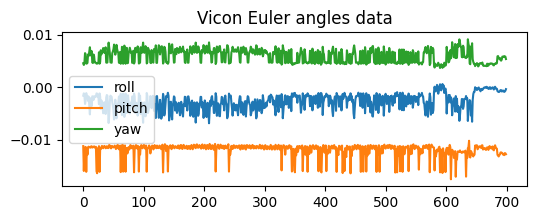

In [7]:
plt.figure(figsize=(6,2))
for i in range(3):
    plt.plot(euler_vicon[i,:700], label = angle_names[i])
plt.legend()
plt.title('Vicon Euler angles data')
plt.show()

In [8]:
vicon['rots'].shape

(3, 3, 5561)

In [ ]:
def accel_raw2physical(accel, bias, sensitivity):
    '''
    Input: accel raw data, bias (beta) and sensitivity (mV/g)
    Output: Ax, Ay, Az in 
    '''
    return (accel - np.ones(accel.shape) * bias) * 3300 / (1023* sensitivity) 

In [5]:
def accel_calibration_train(accel, vicon_rots, N_train):
    '''
    A function that takes in the raw data (accel and vicon rotation matrices), extracts the training set (first 700 data points), 
    It outputs bias (beta) and sensitivity (alpha) for sensor IMU.
    '''
    accel_raw_train = accel[:, :N_train]
    vicon_raw_train = vicon_rots[:,:, :N_train]

    


SyntaxError: invalid syntax (3889891435.py, line 1)